# Unsupervised Learning

Algorithms covered:
- Clustering: K-means
- Dimension Reduction: PCA
- Anomaly detection and density estimation: Gaussian Detection
- Recommender systems: Collaborative filtering

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.covariance import *
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_data(X, y=None, model=None, scale=0.01, figsize=(6, 6), s=20, alpha=0.7, edgecolor='black', labels=None,
              title=''):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    delta = max(x_max - x_min, y_max - y_min)
    h = scale * delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    fig, ax = plt.subplots(figsize=figsize)
    
    classes = None
    if y is not None:
        classes = np.unique(y)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if model is not None:
        if classes is None and labels is not None:
            classes = np.unique(labels)
            colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
        yhat = model.predict(grid).reshape(xx.shape)
        ax.contourf(xx, yy, yhat, alpha=0.1, cmap=plt.cm.rainbow)
        plt.axis('tight')
    
    if y is not None:
        for i, color in zip(classes, colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], color=color, label=f'$y={i}$', edgecolor=edgecolor, s=s, alpha=alpha)
        ax.legend(loc='best')
    else:
        plt.scatter(X[:, 0], X[:, 1], edgecolor=edgecolor, s=s, alpha=alpha)
    
    plt.axis('tight')
    plt.title(title)
    ax.set(aspect='equal', xlabel='$x_1$', ylabel='$x_2$')
    plt.show()

## Clustering

In [4]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=6, cluster_std=1., random_state=seed, shuffle=True)
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

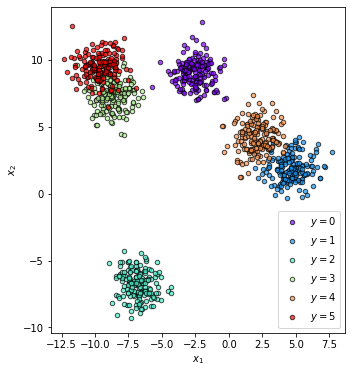

In [6]:
plot_data(X, y=y)

### K-Means Clustering

**Algorithm:** Given data $X$ of shape $n \times p$,
- Randomly initialize $K$ centroids $\boldsymbol{\mu}_1, \cdots, \boldsymbol{\mu}_K \in \mathbb{R}^{p}$.
- Until a stopping criterion is met, do the following:
    - Calculate all distances $d_{ik} = ||\boldsymbol{x}_i-\boldsymbol{\mu}_k||_2^2$ for all $i=1,\cdots,n$ and $k=1,\cdots,K$.
    - Assign each point $\boldsymbol{x}_i$ to some centroid $\boldsymbol{\mu}_k$ with a label $c_i \equiv \text{argmin}_k ||\boldsymbol{x}_i-\boldsymbol{\mu}_k||_2^2$.
    - Update each centroid $\boldsymbol{\mu}_k$ by $\boldsymbol{\mu}_k = \langle \boldsymbol{x}_i \rangle_{c_i=k}$.

**Notes:**
- The loss function that K-Means is implicitly trying to minimize is the average distance of each point to its assigned centroid, called the **inertia** or **distortion**:
$$L(\boldsymbol{c}, \boldsymbol{\mu}|\boldsymbol{X}) = \frac{1}{n} \sum_{i=1}^n ||\boldsymbol{x}_i-\boldsymbol{\mu}_{c_i}||_2^2,$$
where each $\mu_{c_i}$ is the centroid corresponding to the label $c_i$. This essentially has to do with the fact that each sample mean $\boldsymbol{\bar x}$ is the maximum likelihood estimator of its true mean $\boldsymbol{\mu} = \langle \boldsymbol{x} \rangle$.
- Choosing the right value of $K$ can be tricky. One way to do it is the "elbow plot" method, which looks at the loss curve for different $K$ and tries to find an "elbow" in the plot that shows where the loss seems to stop rapidly decreasing.
- A better way to choose $K$ usually is to use whatever metric the downstream task requires, e.g. image quality for image compression, or t-shirt sizes for clustering t-shirt size fits.


**Pseudocode:**
```python
def k_means(X, k, num_iters):
    initialize k centers mu = [mu_1,...,mu_k] in X space
    for i in range(num_iters):
        for each point x in X:
            get distances between x and all centers mu
            assign x to cluster with closest center
        recalculate k centers mu by using the means of points assigned to that cluster
    return final clusters
```

In [7]:
def k_means(X, k=10, num_iters=100, metric=None):
    if metric is None:
        metric = lambda x1, x2: np.sum((x1 - x2)**2, axis=-1)
    num_features = X.shape[1]
    mins, maxes = X.min(axis=0), X.max(axis=0)
    centers = np.random.uniform(low=mins, high=maxes, size=(k, num_features))
    for i in range(num_iters):
        distances = [metric(X, xk) for xk in centers]
        clusters = np.argmin(distances, axis=0).astype(int)
        centers = np.array([np.mean(X[clusters == j], axis=0) for j in range(k)])
    return clusters

y_pred = k_means(X, k=4, num_iters=100)
y_pred.shape, y_pred[:10]

((1000,), array([2, 1, 3, 2, 3, 2, 1, 3, 2, 3]))

In [8]:
class KMeansModel:
    def __init__(self, n_clusters=8, max_iter=300, metric=None, n_init=10):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.metric = metric
        self.n_init = n_init
        
        
    def fit(self, X):
        if self.metric is None:
            self.metric = lambda x1, x2: np.sum((x1 - x2)**2, axis=-1)
        self.num_features = X.shape[1]
        init_labels, init_clusters, init_scores = [], [], []
        for n in range(self.n_init):
            self.cluster_centers = self._init_centers(X, n_clusters=self.n_clusters)
            for i in range(self.max_iter):
                distances = [self.metric(X, xk) for xk in self.cluster_centers]
                clusters = np.argmin(distances, axis=0).astype(int)
                centers = []
                for k in range(self.n_clusters):
                    idxs = (clusters == k)
                    center = np.mean(X[idxs], axis=0) if sum(idxs.astype(int)) > 0 else \
                                self._init_centers(X, n_clusters=1)
                    centers.append(center)
                centers_prev = self.cluster_centers
                self.cluster_centers = np.vstack(centers)
                if np.allclose(self.cluster_centers, centers_prev):
                    break
            init_scores.append(self._inertia(X))
            init_clusters.append(clusters)
            init_labels.append(self.cluster_centers)
        idx = np.argmin(init_scores)
        self.labels = init_clusters[idx]
        self.cluster_centers = init_labels[idx]
            
    def predict(self, X):
        distances = [self.metric(X, xk) for xk in self.cluster_centers]
        y_pred = np.argmin(distances, axis=0).astype(int)
        return y_pred
    
    def score(self, X):
        return self._inertia(X)
        
    def _inertia(self, X):
        centers = self.cluster_centers
        y_pred = self.predict(X)
        return np.sum([np.mean((X[y_pred == k] - centers[k].reshape(1, -1))**2) for k in range(self.n_clusters)])
    
    def _init_centers(self, X, n_clusters=None):
        centers = [X[np.random.choice(range(len(X)))] for k in range(n_clusters)]
        return np.vstack(centers)

In [9]:
model = KMeansModel(n_clusters=len(set(y_train)), max_iter=100)
model.fit(X_train)
y_pred = model.predict(X_test)
y_test.shape, y_pred.shape

((300,), (300,))

In [10]:
model.score(X_train)

5.53092708792541

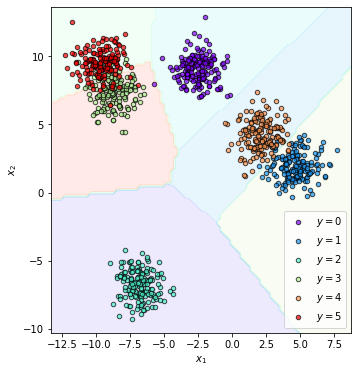

In [11]:
plot_data(X, y=y, model=model, labels=model.labels)

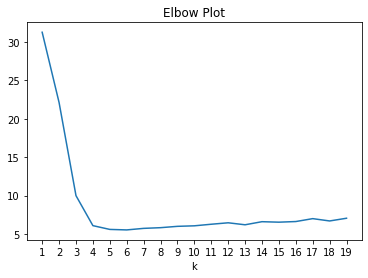

In [12]:
def elbow_plot(Model, max_k=20):
    scores = []
    for k in range(1, 20):
        model = Model(n_clusters=k)
        model.fit(X_train)
        score = model.score(X_train)
        scores.append(score)
    plt.plot(np.arange(1, len(scores) + 1), scores)
    plt.xticks(np.arange(1, len(scores) + 1))
    plt.xlabel('k')
    plt.title('Elbow Plot')
    plt.show()
    
elbow_plot(KMeansModel, max_k=20)

In [13]:
# %load_ext line_profiler

# model = KMeansModel(n_clusters=len(set(y_train)), max_iter=100)

# %lprun -f model.fit model.fit(X_train)

In [14]:
%%timeit

model = KMeansModel(n_clusters=len(set(y_train)))
model.fit(X_train)
y_pred = model.predict(X_test)

33.9 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit

model = KMeans(n_clusters=len(set(y_train)))
model.fit(X_train)
y_pred = model.predict(X_test)

12 ms ± 652 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Dimension Reduction

In [16]:
X, y = make_blobs(n_samples=1000, n_features=20, centers=6, cluster_std=1., random_state=seed, shuffle=True)
X.shape, y.shape

((1000, 20), (1000,))

### PCA

- Covariance matrix of data (when centered): $C = \frac{1}{N-1} X^T X$
- Spectral decomposition of covariance matrix: $C = V \Lambda V^T$
- SVD of data: $X = U \Sigma V^T$
- Covariance-SVD relation: $C = V \frac{\Sigma^2}{N-1} V^T$
- PCA transformation (principle components of $X$): $\hat X = XV = U\Sigma$
- Explained variance (covariance eigenvalues): $\lambda_i = \frac{\sigma_i^2}{N-1}$
- Explained variance ratio (normalized covariance eigenvalues): $\rho_i = \frac{\lambda_i}{\sum \lambda_j}$
- SVD runtime for an $n\times p$ matrix $X$: $O(\min(n^2 p, p^2 n))$

In [17]:
def pca(X, n_components=100):
    U, Sigma, Vt = np.linalg.svd(X)
    Xhat = X @ Vt.T
    return Xhat[:, :n_components]

Xhat = pca(X, n_components=2)
Xhat.shape

(1000, 2)

In [18]:
class PCAModel:
    def __init__(self, n_components=100, whiten=False, svd_solver='reduced'):
        self.n_components = n_components
        self.whiten = whiten
        self.svd_solver = svd_solver
        
    def fit(self, X):
        self.n_samples_, self.n_features_ = X.shape
        if self.n_components > self.n_features_:
            self.n_components = self.n_features_
        self._init_solver()
        self._create_stats(X)
        X = self._normalize(X)
        U, Sigma, Vt = self._svd(X) 
        self.singular_values_ = Sigma
        self.explained_variance_ = Sigma ** 2 / (self.n_samples_ - 1)
        self.explained_variance_ratio_ = self.explained_variance_ / sum(self.explained_variance_)
        self.components_ = Vt.T[:, :self.n_components]
        if self.whiten:
            self.components_ *= self.n_samples_ / self.singular_values_.reshape(-1, 1)
            
    def transform(self, X):
        X = self._normalize(X)
        return X @ self.components_
    
    def inverse_transform(self, Xhat):
        X = Xhat @ self.components_.T
        X = self.std_ * X + self.mean_
        return X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def score(self, X):
        # score is R^2 of reconstructed projection vs true data
        Xhat = self.transform(X)
        X_rec = self.inverse_transform(Xhat)
        return 1 - np.sum((X_rec - X)**2) / np.sum(X**2)
    
    def plot_explained_variance(self):
        cum_exp_var, exp_var = np.cumsum(self.explained_variance_ratio_), self.explained_variance_ratio_
        x = np.arange(0, len(exp_var))
        plt.bar(x, exp_var, alpha=0.5, align='center')
        plt.step(x, cum_exp_var, where='mid')
        plt.xticks(x)
        plt.ylabel('explained variance ratio')
        plt.xlabel('principal components')
        plt.tight_layout()
        plt.show()
    
    def _create_stats(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        
    def _normalize(self, X):
        return (X - self.mean_) / self.std_
    
    def _init_solver(self):
        from functools import partial
        import fbpca
        k = max(self.n_components, min(self.n_features_, 100))
        if self.svd_solver == 'reduced':
            self._svd = partial(np.linalg.svd, full_matrices=False)
        elif self.svd_solver == 'full':
            self._svd = partial(np.linalg.svd, full_matrices=True)
        elif self.svd_solver == 'randomized':
            self._svd = partial(self._randomized_svd, k=k)
        elif self.svd_solver == 'fbpca':
            self._svd = partial(fbpca.pca, k=k)
    
    @staticmethod
    def _randomized_svd(X, k=100):
        # more stable implementation: fbpca (from facebook)
        n, p = X.shape
        transpose = (n < p)
        X = X.T if n < p else X
        M_rand = np.random.normal(size=(min(n, p), k))
        Q, _ = np.linalg.qr(X @ M_rand, mode='reduced')
        X_rand = Q.T @ X
        U_hat, Sigma, Vt = np.linalg.svd(X_rand, full_matrices=False)
        U = Q @ U_hat
        return (Vt.T, Sigma.T, U.T) if transpose else (U, Sigma, Vt)

In [19]:
model = PCAModel(n_components=2, whiten=False, svd_solver='fbpca')
Xhat = model.fit_transform(X)
model.score(X)

0.6357449664399071

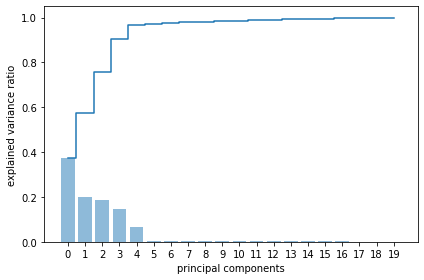

In [20]:
model.plot_explained_variance()

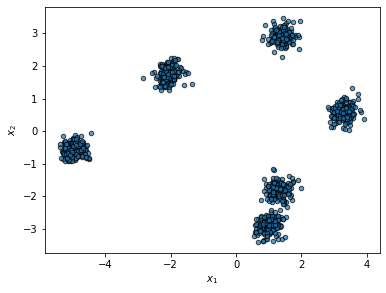

In [21]:
plot_data(Xhat)

In [22]:
X_tmp, _ = make_blobs(n_samples=10_000, n_features=1000, centers=6, cluster_std=1., random_state=seed, shuffle=True)
X_tmp.shape

(10000, 1000)

In [23]:
%%timeit

model = PCAModel(n_components=100, svd_solver='fbpca')
Xhat_tmp = model.fit_transform(X_tmp)

1.51 s ± 93.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit

model = PCA(n_components=100, svd_solver='randomized')
Xhat_tmp = model.fit_transform(X_tmp)

2.5 s ± 83.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Anomaly Detection and Density Estimation

- Density Estimation: Given a dataset $X$ of $n$ examples, estimate the probability density $p(X)$.
- Anomaly Detection: Use the density $p(X)$ to assign an "anomaly score" to examples with low probability, e.g. anomalies are any $x$ such that $p(x) < \varepsilon$.
- Given some labeled anomalies, one can also try to build a supervised algorithm to predict anomalies directly. This can work better, but getting enough training examples can be a challenge.
- One density model to fit a multivariate Gaussian $\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ model to the data $\boldsymbol{X}$. The mean vector $\boldsymbol{\mu}$ and covariance matrix $\Sigma$ can be estimated from the data using the MLE estimates
$$\boldsymbol{\hat \mu} = \frac{1}{n} \sum_{i=1}^n \boldsymbol{x}_i,$$
$$\boldsymbol{\hat \Sigma} = \frac{1}{n} \sum_{i=1}^n (\boldsymbol{x}_i - \boldsymbol{\hat \mu})(\boldsymbol{x}_i - \boldsymbol{\hat \mu})^T.$$
- In the even simpler case where one assumes the features are IID, we get a product of univariate Gaussians $\mathcal{N}(\mu_j, \sigma_j^2)$, where for each feature $\boldsymbol{x}_j$ we have MLEs
$$\hat \mu_j = \frac{1}{n} \sum_{i=1}^n x_{ij},$$
$$\hat \sigma_j^2 = \frac{1}{n} \sum_{i=1}^n (x_{ij}-\hat \mu_j)^2.$$
- To perform anomaly detection on a sample $\boldsymbol{x}$ with a Gaussian estimator, we just need to calculate $p(\boldsymbol{x})$, which is given in the IID features case by
$$p(\boldsymbol{x}) = \prod_{j=1}^p p(x_j) = \prod_{j=1}^p \frac{1}{\sqrt{2\pi \sigma_j^2}} \exp{\bigg(-\frac{(x_j-\mu_j)^2}{2\sigma_j^2}}\bigg).$$
- If a few labeled anomalies are available, they can be used to score the effectiveness of the detection algorithm. In the case where we only have a small number of labels, we can "train" a model by fitting a density to some unlabeled training data, and then evaluate how well that model does in predicting the labeled examples in the test set.
- If more than a small number of labels are available, we can instead try to train a (heavily unbalanced) supervised anomaly detection algorithm, which can sometimes work better. This may be useful if the anomalies exhibit a particular pattern that the model can learn, if that pattern doesn't drift much over time, and if there are enough labels to learn the pattern from the training data. If not, it may still be better to use the unsupervised approach.
- Example: If your problem is fraud detection, where approaches might rapidly evolve and are hard to catch, you my opt for an unsupervised approach. If your problem is spam, where approaches don't change that quickly and it's relatively easy to get labeled data, you might opt for a supervised approach.
- For unsupervised anomaly detection, feature engineering and selection is *much* more important than it is in supervised learning. Having the wrong features can completely throw off your ability to detect anomalies in this way.
- For example, if you have features that aren't Gaussian because they have a skew, you can try using log or power law transformations to make the feature look more Gaussian, and then use that as a detection feature.
- When looking for good features to use, look for features that result in high probabilities for normal examples and low probabilities for any labeled anomaly examples.

In [25]:
def gaussian_params(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return mu, sigma

def gaussian_pdf(X, mu, sigma):
    exp = (-1/2 * (X - mu)**2 / sigma**2).sum(axis=-1)
    p = np.exp(exp)
    p *= np.prod((2 * np.pi * sigma)**(-1/2))
    return p

def gaussian_anomalies(X, mu, sigma, eps=1e-4):
    p = gaussian_pdf(X, mu, sigma)
    return X[p < eps]

In [26]:
X = np.random.normal(loc=[1.5, -1], scale=[1, 2], size=(100, 2))
X.shape

(100, 2)

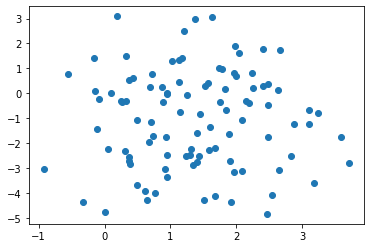

In [27]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [28]:
mu, sigma = gaussian_params(X)
mu, sigma

(array([ 1.36879011, -1.03995575]), array([0.96932622, 1.9263537 ]))

In [29]:
gaussian_pdf([1.5, -1], mu, sigma), gaussian_pdf([-10, 0], mu, sigma)

(0.11538383167246019, 1.3564481608004355e-31)

In [30]:
gaussian_anomalies(X, mu, sigma, eps=1e-2)

array([[ 3.17299079, -3.60405241],
       [ 3.70261824, -2.81309404],
       [-0.91574638, -3.0536196 ],
       [-0.33385072, -4.38217254],
       [ 0.00750825, -4.74941195],
       [ 2.46312977, -4.8406053 ],
       [ 3.58665355, -1.7526736 ],
       [ 0.18320224,  3.0915617 ]])

In [31]:
class GaussianAnomalyDetector:
    def __init__(self, threshold=1e-4):
        self.threshold = threshold
    
    def fit(self, X):
        self.means = np.mean(X, axis=0)
        self.std_devs = np.std(X, axis=0)
    
    def predict(self, X):
        y_prob = self.predict_proba(X)
        y_pred = (y_prob < self.threshold).astype(int)
        return y_pred
    
    def predict_proba(self, X):
        exp = (-1/2 * (X - self.means)**2 / self.std_devs**2).sum(axis=-1)
        y_prob = np.exp(exp)
        y_prob *= np.prod((2 * np.pi * self.std_devs)**(-1/2))
        return y_prob

In [32]:
model = GaussianAnomalyDetector(threshold=1e-2)
model.fit(X)
y_pred = model.predict(X)
y_pred.shape

(100,)

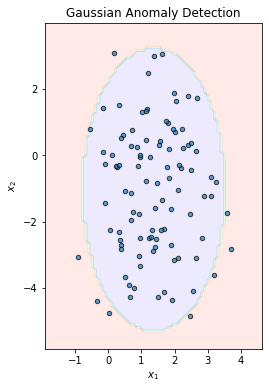

In [33]:
plot_data(X, model=model, title='Gaussian Anomaly Detection')

In [39]:
%%timeit

model = GaussianAnomalyDetector(threshold=1e-2)
model.fit(X)
y_pred = model.predict(X)

25.6 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
%%timeit

model = EllipticEnvelope(contamination=0.08, random_state=seed)
model.fit(X)
y_pred = model.predict(X)

6.83 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Recommender Systems

### Collaborative Filtering
- **Collaborative Filtering:** Recommend items to you based on users who gave similar items to you.
- Collaborative filtering can be thought of as a form of unsupervised learning where the input features aren't known, but the output targets are known for each example.
- The hidden input features are called **latent factors**. These have to be learned along with the model parameters. The number of latent factors must be specified in advance.
- In recommender systems, the input examples are called **users** and the output labels are called **items**. The values the outputs take on are called **ratings**.
- Examples of possible problems involving CF (or any rec system) might be: predicting movie (or song, or product) ratings for users, predicting the probability a user will click on an ad, or predicting how long a user will spend engaging with the item.
- Example: Suppose a set of 20 users rates a few movies they watched out of a set of 100 movies. Each user won't usually have seen all 100 movies (or perhaps any at all). Thinking of each user as examples (with hidden features), the goal is to predict which movie they'd like (i.e. pick one of 100 items).
- CF problems are typically presented in a crosstab form of users vs items. The values in the table are the ratings (or predictions). Missing output values are left blank, or filled with zeros or NaNs.
- For example:
|   |Movie 1|Movie 2|Movie 3|Movie 4|
|---|---|---|---|---|
|**User 1**|5|   |   |1|
|**User 2**|   |2|4|   |
|**User 3**|1|4|   |4|
- In programming languages, CF data is usually represented in a different format of user, item, rating like this:
|User|Movie|Rating|
|---|---|---|
|1|1|5|
|1|4|1|
|2|2|2|
|2|3|4|
|3|1|1|
|3|2|4|
|3|4|4|

- One needs to specify ahead of time how many users $N$ there are along with how many latent factors $f$ will be used to predict the missing ratings for each user.
- To predict the rating of item $j$ for user $i$, we'll use the linear model
$$\hat Y_{ij} = v_j \cdot u_i + b_j.$$
- For interpretability it's common in CF to break up the bias into two vectors, a user bias $b_U$ and an item bias $b_I$.
-Across all users and items, the full item embeddings $V$ have shape $(K,F)$ and the user embeddings $U$ have shape $(F,N)$, giving ratings $Y$ of shape $(K,N)$. In this form we have
$$\hat Y = UV + b_U + b_I.$$
- The loss function optimized in such a CF problem is the MSE loss across all users, but only on the $i,j$ pairs that were actually rated:
$$L(\hat Y, Y) = \sum_{i=1}^N \sum_{j:Y_{ij} \neq \emptyset}^K (\hat Y_{ij} - Y_{ij})^2.$$
- In typical applications, most ratings $Y_{ij}$ are empty, meaning $Y$ would be sparse. Because of this, and since $W,U$ just involve looking up indexes in arrays, they're typically implemented as embeddings instead of dense matrices that get matrix multiplied.
- When the ratings take on a bounded range (e.g. movie ratings from 1-5) it's a good idea to use a rescaled sigmoid activation function before making predictions, so $\hat Y = \sigma_{min,max}(UV + b_U + b_I)$. In this case, the BCE loss would be used, appropriately rescaled.
- To make a better CF model, we can take the user and item embeddings, concat them together, and then feed them through a few MLP layers
$$
\begin{align}
A_1 &= \sigma_1(W_1 [U, V] + b_1), \\
A_2 &= \sigma_2(W_2 A_1 + b_2), \\
\vdots & \qquad \vdots \\
\hat Y &= \sigma_L(W_L A_{L-1} + b_L).
\end{align}
$$
- Nowadays, RS engineers often use a combination of both the vanilla dot product model ensembled with a deep learning model.
- A DL model is most useful when you have metadata on your users that you may also want to combine with the user/item information you have. An example where metadata would be useful is for the **cold start problem**: when you have a new user (or item) who hasn't yet rated anything yet. Then, you can use their metadata to try to build their initial ratings.
- One way to deal with the cold start problem (that's not so good, but okay to start with) is to center the data by the item means, called mean normalization. So $Y \rightarrow Y - M$, where $M$ is the item vector means of $Y$. This will ensure that any new users get initialized with mean ratings for all items. There are problems with this, but it's better than nothing.
- To find related items to a particular item, you can use something cosine similarity or Euclidean distance. Similar for related users to a particular user. For a particular user embedding $u_i$, you'd search for the most similar user embedding $u_j$. Similar for items.
- We can visualize the parameters $U, V, b_U, b_I$ of a CF model as well. The parameters $b_U, b_I$ can be ranked to give a list of the (average) most popular items using $b_I$, or the users who tended to give the highest ratings using $b_U$. We can do a 2D dimension reduction on $U$ and $V$ to also visualize how items and users cluster together in the latent space.

In [81]:
df = pd.DataFrame({'User': [0, 0, 1, 1, 2, 2, 2], 'Movie': [0, 3, 1, 2, 0, 1, 3], 'Rating': [5, 1, 2, 4, 1, 4, 4]})
df

,User,Movie,Rating
0,0,0,5
1,0,3,1
2,1,1,2
3,1,2,4
4,2,0,1
5,2,1,4
6,2,3,4


In [82]:
crosstab = pd.pivot_table(df, values='Rating', index=['User'], columns=['Movie'], fill_value='')
crosstab

Movie,0,1,2,3
User,,,,
0,5.0,,,1.0
1,,2.0,4.0,
2,1.0,4.0,,4.0


In [83]:
N = len(df.User.unique())
F = 2
K = len(df.Movie.unique())
N, F, K

(3, 2, 4)

In [84]:
Y = crosstab.replace('', 0).values.T
V = np.random.rand(K, F)
U = np.random.rand(F, N)
b = np.random.rand(K).reshape(-1, 1)
Y.shape, V.shape, U.shape, b.shape

((4, 3), (4, 2), (2, 3), (4, 1))

In [85]:
Yhat = V @ U + b
Y.T, Yhat.T

(array([[5., 0., 0., 1.],
        [0., 2., 4., 0.],
        [1., 4., 0., 4.]]),
 array([[0.78620172, 1.29398296, 1.55760498, 0.78897237],
        [0.98664219, 1.30484867, 1.39097068, 0.73167917],
        [0.99660789, 1.10851614, 1.16650266, 0.62850921]]))

In [86]:
m, M = 0, 5.5 # make largest a little bigger than max rating
sigmoid_range = lambda z: (M - m) * 1 / (1 + np.exp(-z)) + m

In [87]:
Yhat = sigmoid_range(V @ U + b)
Y_pred = Yhat.round()
Y.T, Yhat.T, Y_pred.T

(array([[5., 0., 0., 1.],
        [0., 2., 4., 0.],
        [1., 4., 0., 4.]]),
 array([[3.77858352, 4.31651321, 4.54305178, 3.7818585 ],
        [4.006333  , 4.32657432, 4.40410939, 3.71345506],
        [4.0171512 , 4.13518804, 4.19381751, 3.58683245]]),
 array([[4., 4., 5., 4.],
        [4., 4., 4., 4.],
        [4., 4., 4., 4.]]))

In [92]:
import torch
from torch import nn

class CollaborativeFilterModel(nn.Module):
    def __init__(self, n_users, n_items, n_latent=100):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_latent = n_latent
        self.user_emb = nn.Embedding(n_users, n_latent)
        self.item_emb = nn.Embedding(n_items, n_latent)
        self.user_bias = nn.Embedding(self.n_users, 1)
        self.item_bias = nn.Embedding(self.n_items, 1)
    
    def forward(self, x):
        # x.shape = (n_rows, 2)
        # y.shape = (n_rows, 1)
        u = self.user_emb(x[:, 0])
        v = self.item_emb(x[:, 1])
        y = (u * v).sum(dim=1, keepdim=True)
        y += self.user_bias(x[:, 0]) + self.item_bias(x[:, 1])
        return y

n_users = len(df.User.unique())
n_latent = 2
n_items = len(df.Movie.unique())
X = torch.tensor(df[['User', 'Movie']].values).long()

model = CollaborativeFilterModel(n_users, n_items, n_latent)
Yhat = model(X).detach()

Yhat, X.shape, Yhat.shape

(tensor([[-2.7787],
         [ 1.5214],
         [ 0.0654],
         [-1.6754],
         [-6.0264],
         [-3.7649],
         [ 0.1526]]),
 torch.Size([7, 2]),
 torch.Size([7, 1]))

### Content-Based Filtering

- **Content-Based Filtering:** Recommend items to you based on based on *features* of users and items to find a good match.
- Unlike CF, CBF is a fully supervised algorithm. Take in inputs features of users and items, predict ratings.
- A CBF reduces to a regular tabular data problem. Any usual techniques or supervised models might apply.
- Examples of user features might be age, gender, location, movies watched, or average rating per genre.
- Examples of item features might be year released, genre, critic movie reviews, or average rating of that movie.
- Suppose $\boldsymbol{x}_U$ is the vector of user features and $\boldsymbol{x}_I$ is the vector of item features. Then, provided we can map those vectors to some outputs $\boldsymbol{v}_U, \boldsymbol{v}_I$ of the same size, we can take their dot products to predict how that user will rate that item: $\hat y = \boldsymbol{v}_U \cdot \boldsymbol{v}_I$.
- To get the vectors $\boldsymbol{v}_U, \boldsymbol{v}_I$, we can train neural networks for each one. Train a user neural net to take $\boldsymbol{v}_U = f(\boldsymbol{x}_U)$, and an item network to take $\boldsymbol{v}_I = f(\boldsymbol{x}_I)$.
- It usually helps a little to vector normalize $\boldsymbol{v}_U, \boldsymbol{v}_I$ after computing them, which helps keep everything well scaled before calculating the predictions.
- The loss function used to train such a dual neural network model is the combined MSE
$$L(\hat Y, Y) = \sum_{i=1}^N \sum_{j:Y_{ij} \neq \emptyset}^K \big((\boldsymbol{v}_U \cdot \boldsymbol{v}_I)_{ij} - Y_{ij}\big)^2.$$
- For binary ratings, we can feed each of $\boldsymbol{v}_U, \boldsymbol{v}_I$ through a sigmoid after taking their dot product to ensure each prediction $0 \leq \hat y \leq 1$.
- The prediction vectors $\boldsymbol{v}_U, \boldsymbol{v}_I$ can each be used to determine similarity with other users and items, similar to how user and item embedding vectors are used in CF.
- Thanks to the presence of user and item features, we avoid the cold start problem with CBF. The tradeoff is that with CBF, good feature engineering of user and items is very important, and will strongly affect performance.
- In many industrial recommender system situations (e.g. ads, movie recs, song recs, product recs), there are a huge amount of users and items to deal with, so trying to do CBF inference in real time for each user can be quite slow. 
    - A way around this is to do what's called retrieval and ranking steps. The idea is to use a heuristic to quickly retrieve the top few hundred items a user might like, and then only do the CBF ranking for that user using those items. 
    - Another thing one can do is cache the item vectors $\boldsymbol{v}_I$ since they won't change as much, and just calculate $\boldsymbol{v}_U$ in real time.
    - Any significant model tuning or recalculations of these vectors can be done overnight and saved in a database.

## Reinforcement Learning